In [4]:
import sys
sys.path.append('../')

from cogsci2017.environment.arm_diva_env import CogSci2017Environment
from cogsci2017.learning.supervisor import Supervisor
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

iterations = 30000

environment = CogSci2017Environment(gui=False, audio=False)


config = dict(m_mins=environment.conf.m_mins,
             m_maxs=environment.conf.m_maxs,
             s_mins=environment.conf.s_mins,
             s_maxs=environment.conf.s_maxs)

agent = Supervisor(config, model_babbling="random", n_motor_babbling=1000, explo_noise=0.05)



human sounds ['eou', 'eyu', 'yeo', 'uye', 'iuo', 'oey']


In [ ]:
for i in range(iterations):
    if i % (iterations/10) == 0:
        print "Iteration", i
    context = environment.get_current_context()
    m = agent.produce(context)
    s = environment.update(m)
    agent.perceive(s)
#    s_traj = environment.diva_traj
#    if s_traj is not None:
#        if i < 100:
#            plt.plot([-f[1] for f in s_traj], [-f[0] for f in s_traj], color="r", alpha=0.2)
#        else:
#            plt.plot([-f[1] for f in s_traj], [-f[0] for f in s_traj], color="b", alpha=0.2)
#            
#plt.xlim([-11.25,-9.5])
#plt.ylim([-9.25, -7.5])

Iteration 0
best_vocal_errors [('eou', 0.70925875178580111), ('eyu', 0.71117887168807681), ('yeo', 0.64667576597725873), ('uye', 0.902256864907103), ('iuo', 1.0588182071744632), ('oey', 0.6059176823765049)]

----------------
Agent Statistics
----------------

#Iterations: 1000

# Chosen module mod1 : 0
# Chosen module mod2 : 0
# Chosen module mod3 : 0
# Chosen module mod4 : 0
# Chosen module mod5 : 0
# Chosen module mod6 : 0
# Chosen module mod10 : 0
# Chosen module mod11 : 0
# Chosen module mod12 : 0
# Chosen module mod13 : 0

Competence progress of mod1  :  0.0
Competence progress of mod2  :  0.0
Competence progress of mod3  :  0.0
Competence progress of mod4  :  0.0
Competence progress of mod5  :  0.0
Competence progress of mod6  :  0.0
Competence progress of mod10 :  0.0
Competence progress of mod11 :  0.0
Competence progress of mod12 :  0.0
Competence progress of mod13 :  0.0

Prediction progress of mod1  :  0.0
Prediction progress of mod2  :  0.0
Prediction progress of mod3  :  0

error oiy 0.787985083408


(-9.25, -7.5)

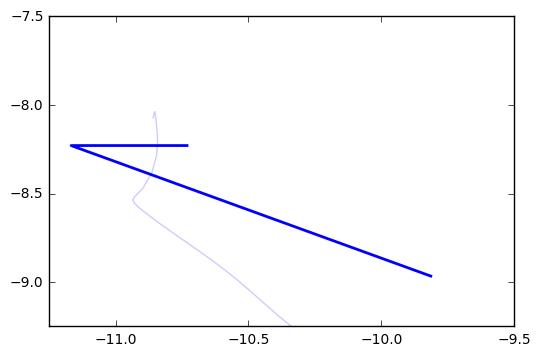

In [4]:
#for hs in human_sounds:
hs = "oiy"
agent.modules["mod13"].sm.sigma_expl = np.array([0.1]*28)
#print agent.modules["mod13"].sm.sigma_expl
m = agent.modules["mod13"].inverse(np.array(environment.human_sounds_traj_std[hs]), explore=True) 
#print m
s = environment.update([0.]*21 + list(m))
s_traj = environment.diva_traj
#print s_traj
error = np.linalg.norm(np.array(environment.human_sounds_traj[hs]) - np.array([f[0] for f in s_traj[[0, 12, 24, 37, 49]]] + [f[1] for f in s_traj[[0, 12, 24, 37, 49]]]))
print "error", hs, error


plt.plot([-f[1] for f in s_traj], [-f[0] for f in s_traj], color="b", alpha=0.2)    
plt.plot(- np.array(environment.human_sounds_traj[hs][5:]), -np.array(environment.human_sounds_traj[hs][:5]), lw=2)

plt.xlim([-11.25,-9.5])
plt.ylim([-9.25, -7.5])

In [3]:

for i in range(100):
    context = environment.get_current_context()[:4]
    s_goal = [2. * np.random.random() - 1. for _ in range(10)]

    m = agent.modules["mod10"].inverse(np.array(context + s_goal), explore=True)
    m = [0.] * 21 + list(m)
    s = environment.update(m)
    if environment.produced_sound:
        print environment.produced_sound
    agent.perceive(s)

In [3]:
print agent.modules["mod10"].sm.model.imodel.fmodel.dataset.data[1]

[]


In [3]:
# TEST EVAL
n_goals = 1

eval_results = {}

for region in [1]:  
    print
    print "region", region
    eval_results[region] = {}
    for i in range(n_goals):
        eval_results[region][i] = {}
        #environment.reset_toys()
        print environment.get_current_context()
        print environment.current_toy1
        for toy in ["toy1"]:
            print
            print toy
            eval_results[region][i][toy] = {}
                                    
            if toy == "toy1":
                goal = [environment.current_toy1[0] * (1. - t) / 2. for t in [0., 0.3, 0.5, 0.8, 1.]] + \
                       [environment.current_toy1[1] * (1. - t) / 2. for t in [0., 0.3, 0.5, 0.8, 1.]]
                arm_mid = "mod3"
                diva_mid = "mod10"
            elif toy == "toy2":
                goal = [environment.current_toy2[0] * (1. - t) / 2. for t in [0., 0.3, 0.5, 0.8, 1.]] + \
                       [environment.current_toy2[1] * (1. - t) / 2. for t in [0., 0.3, 0.5, 0.8, 1.]]
                arm_mid = "mod4"
                diva_mid = "mod11"
            elif toy == "toy3":
                goal = [environment.current_toy3[0] * (1. - t) / 2. for t in [0., 0.3, 0.5, 0.8, 1.]] + \
                       [environment.current_toy3[1] * (1. - t) / 2. for t in [0., 0.3, 0.5, 0.8, 1.]]
                arm_mid = "mod5"
                diva_mid = "mod12"
                
            print "goal", i, goal
            print "context", environment.get_current_context()
            context = list(agent.modules[arm_mid].get_c(environment.get_current_context()))
            dists, _ = agent.modules[arm_mid].sm.model.imodel.fmodel.dataset.nn_y(context+goal)
            arm_dist = dists[0]
            
            if len(agent.modules[diva_mid].sm.model.imodel.fmodel.dataset) > 0:
                context = list(agent.modules[diva_mid].get_c(environment.get_current_context()))
                dists, _ = agent.modules[diva_mid].sm.model.imodel.fmodel.dataset.nn_y(context+goal)
                diva_dist = dists[0]
            else:
                diva_dist = np.inf
            
            print "arm dist", arm_dist
            print "diva_dist", diva_dist
            
            if arm_dist < diva_dist:
                m = agent.modules[arm_mid].inverse(np.array(context + goal), explore=False)            
                m = list(m) + [0.]*28
            else:
                m = agent.modules[diva_mid].inverse(np.array(context + goal), explore=False)            
                m = [0.]*21 + list(m)
                
            s = environment.update(m)
            print "s", s
            
            if toy == "toy1":
                reached = s[30:40]
            elif toy == "toy2":
                reached = s[40:50]
            elif toy == "toy3":
                reached = s[50:60]
                
            comp_error = np.linalg.norm(np.array(reached) - np.array(goal))
            print "reached", reached, "error", comp_error
            
            eval_results[region][i][toy]["comp_error"] = comp_error
            eval_results[region][i][toy]["arm_dist"] = arm_dist
            eval_results[region][i][toy]["diva_dist"] = diva_dist


region 1
[0.016729916774849474, 0.011570363769717658, -0.99640005054696501, -0.0093089259173685934, -0.9632986964975625, -0.23509882223928605, -0.059157591036650796, 0.011432153668449626, -0.8108398599647739, 0.47994354661050065]
[-1.99280010109393, -0.018617851834737187, 0.0]

toy1
goal 0 [-0.99640005054696501, -0.69748003538287551, -0.49820002527348251, -0.19928001010939295, -0.0, -0.0093089259173685934, -0.0065162481421580151, -0.0046544629586842967, -0.0018617851834737183, -0.0]
context [0.016729916774849474, 0.011570363769717658, -0.99640005054696501, -0.0093089259173685934, -0.9632986964975625, -0.23509882223928605, -0.059157591036650796, 0.011432153668449626, -0.8108398599647739, 0.47994354661050065]
arm dist 1.38684805606
diva_dist inf
s [ 0.01672992  0.01157036 -0.99640005 -0.00930893 -0.9632987  -0.23509882
 -0.05915759  0.01143215 -0.81083986  0.47994355 -0.01474219 -0.17402559
 -0.12120461 -0.008477   -0.07120605  0.48866397  0.1672987   0.17333589
 -0.01331745 -0.09086768

In [16]:
print environment.get_current_context()
print environment.current_toy1

[-0.25, 0.0, 0.73993542908577359, -0.1445236240803919, 0.87577977025799236, -0.28002212906596963, -0.18408930766778922, 0.053627922743935533, 0.8536357265884991, -0.5145681760294718]
[1.4798708581715472, -0.28904724816078381, 0.0]
